In [1]:
import numpy as np
import pandas as pd
import os
import gc
import re
import string
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import hstack, csr_matrix

import nltk
from nltk.corpus import stopwords 
nltk.download('stopwords')

lentrain = 1503424
lentest = 508438
lentrainactive = 14129821
lentestactive = 12824068

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\osk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def cleanName(text):
    try:
        textProc = text.lower()
        # textProc = " ".join(map(str.strip, re.split('(\d+)',textProc)))
        #regex = re.compile(u'[^[:alpha:]]')
        #textProc = regex.sub(" ", textProc)
        textProc = re.sub('[!@#$_“”¨«»®´·º½¾¿¡§£₤‘’]', '', textProc)
        textProc = " ".join(textProc.split())
        return textProc
    except: 
        return "name error"


In [3]:
train = pd.read_csv('../input/train.csv', usecols=['description', 'title', 'param_1', 'param_2', 'param_3'])
test = pd.read_csv('../input/test.csv', usecols=['description', 'title', 'param_1', 'param_2', 'param_3'])

train['title'] = train['title'].fillna('missing')
train['description'] = train['description'].fillna('missing')
train['param_1'] = train['param_1'].fillna('missing')
train['param_2'] = train['param_2'].fillna('')
train['param_3'] = train['param_3'].fillna('')
train['title'] = train['title'].apply(lambda x: cleanName(x))
train["description"]   = train["description"].apply(lambda x: cleanName(x))
train['param_1'] = train['param_1'].apply(lambda x: cleanName(x))
train['param_2'] = train['param_2'].apply(lambda x: cleanName(x))
train['param_3'] = train['param_3'].apply(lambda x: cleanName(x))


test['title'] = test['title'].fillna('missing')
test['description'] = test['description'].fillna('missing')
test['param_1'] = test['param_1'].fillna('missing')
test['param_2'] = test['param_2'].fillna('')
test['param_3'] = test['param_3'].fillna('')
test['title'] = test['title'].apply(lambda x: cleanName(x))
test["description"]   = test["description"].apply(lambda x: cleanName(x))
test['param_1'] = test['param_1'].apply(lambda x: cleanName(x))
test['param_2'] = test['param_2'].apply(lambda x: cleanName(x))
test['param_3'] = test['param_3'].apply(lambda x: cleanName(x))

train['title_description'] = (train['title']+" "+train['description']).astype(str)
train['title_param'] = (train['title']+' '+train['param_1']+' '+train['param_2']+' '+train['param_3']).astype(str)
train.drop(['description', 'title', 'param_1', 'param_2', 'param_3'], axis=1, inplace=True)

test['title_description'] = (test['title']+" "+test['description']).astype(str)
test['title_param'] = (test['title']+' '+test['param_1']+' '+test['param_2']+' '+test['param_3']).astype(str)
test.drop(['description', 'title', 'param_1', 'param_2', 'param_3'], axis=1, inplace=True)

print(train.shape)
print(test.shape)

(1503424, 2)
(508438, 2)


In [ ]:
df = pd.concat([train, test])
print(df.shape)

In [5]:
russian_stop = set(stopwords.words('russian'))
tfidf_para = {
    "stop_words": russian_stop,
    "analyzer": 'word',
    "token_pattern": r'\w{1,}',
    "sublinear_tf": True,
    "dtype": np.float32,
    "norm": 'l2',
    "smooth_idf":False
}

def get_col(col_name):
    return lambda x: x[col_name]

vectorizer = FeatureUnion([
        ('title_description',TfidfVectorizer(
            ngram_range=(1, 2),
            max_features=17000,
            **tfidf_para,
            preprocessor=get_col('title_description'))),
        ('title_param',CountVectorizer(
            ngram_range=(1, 2),
            stop_words = russian_stop,
            preprocessor=get_col('title_param')))
    ])

vectorizer.fit(df.to_dict('records'))
ready_df = vectorizer.transform(df.to_dict('records'))


In [6]:
ready_df.shape

(2011862, 1726281)

In [22]:
train_df = ready_df[:lentrain]
y = pd.read_csv('../input/train.csv', usecols=['deal_probability'])


(1503424, 1726281)

In [23]:
ridge_params = {'alpha':30.0, 'fit_intercept':True, 'normalize':False, 'copy_X':True,
                'max_iter':None, 'tol':0.001, 'solver':'auto', 'random_state':786}
ridge = Ridge(**ridge_params)
ridge.fit(train_df, y)
pred_ridge = ridge.predict(ready_df)


In [33]:
train_ridge = pred_ridge[:lentrain]
test_ridge = pred_ridge[lentrain:]

print(train_ridge.shape)
print(test_ridge.shape)


(1503424, 1)
(508438, 1)


In [34]:
train_ridge_df = pd.DataFrame()
test_ridge_df = pd.DataFrame()
train_ridge_df['tfidf_td_counttp_ridge'] = pd.Series(train_ridge.flatten())
test_ridge_df['tfidf_td_counttp_ridge'] = pd.Series(test_ridge.flatten())

train_ridge_df.to_feather('../features/train/tfidf_td_counttp_ridge_train.feather')
test_ridge_df.to_feather('../features/test/tfidf_td_counttp_ridge_test.feather')


In [35]:
del train_df, y, ridge, pred_ridge, train_ridge, test_ridge, train_ridge_df, test_ridge_df
gc.collect()

573

In [7]:
n_comp = 7
tsvd = TruncatedSVD(n_components=n_comp, algorithm='arpack')
pred_tsvd = tsvd.fit_transform(ready_df)

train_svd = pd.DataFrame(pred_tsvd[:lentrain])
test_svd = pd.DataFrame(pred_tsvd[lentrain:])
train_svd.columns = ['svd_tfidf_td_counttp_'+str(i+1) for i in range(n_comp)]
test_svd.columns =  ['svd_tfidf_td_counttp_'+str(i+1) for i in range(n_comp)]

print(train_svd.shape)
print(test_svd.shape)
train_svd.head()


(1503424, 7)
(508438, 7)


,svd_tfidf_td_counttp_1,svd_tfidf_td_counttp_2,svd_tfidf_td_counttp_3,svd_tfidf_td_counttp_4,svd_tfidf_td_counttp_5,svd_tfidf_td_counttp_6,svd_tfidf_td_counttp_7
0,0.001534,0.001379,0.000371,0.000184,0.001222,0.001553,0.000818
1,0.018931,0.003123,0.001861,0.002360,0.029123,0.003147,0.002795
2,0.004155,0.004870,0.000627,0.000704,0.004269,0.003596,-0.000188
3,0.002833,0.007087,-0.001822,0.001102,0.003681,0.010793,-0.000540
4,0.001063,0.003465,-0.000660,0.000945,0.005391,0.006716,0.001371


In [8]:
test_svd.head()

,svd_tfidf_td_counttp_1,svd_tfidf_td_counttp_2,svd_tfidf_td_counttp_3,svd_tfidf_td_counttp_4,svd_tfidf_td_counttp_5,svd_tfidf_td_counttp_6,svd_tfidf_td_counttp_7
0,0.167345,0.102180,0.150162,-0.016680,1.063206,-0.036857,-0.010652
1,0.045838,0.419654,-0.204260,0.001974,0.030034,0.291563,-0.028960
2,0.003048,0.005567,-0.000682,0.001268,0.002815,0.005138,0.000174
3,0.004797,0.017048,-0.007456,0.000256,0.001802,0.012933,-0.001032
4,0.009655,0.022582,0.008219,0.007578,0.044346,0.021044,0.001821


In [9]:
train_svd.to_feather('../features/train/tfidf_td_counttp_tsvd_train.feather')
test_svd.to_feather('../features/test/tfidf_td_counttp_tsvd_test.feather')


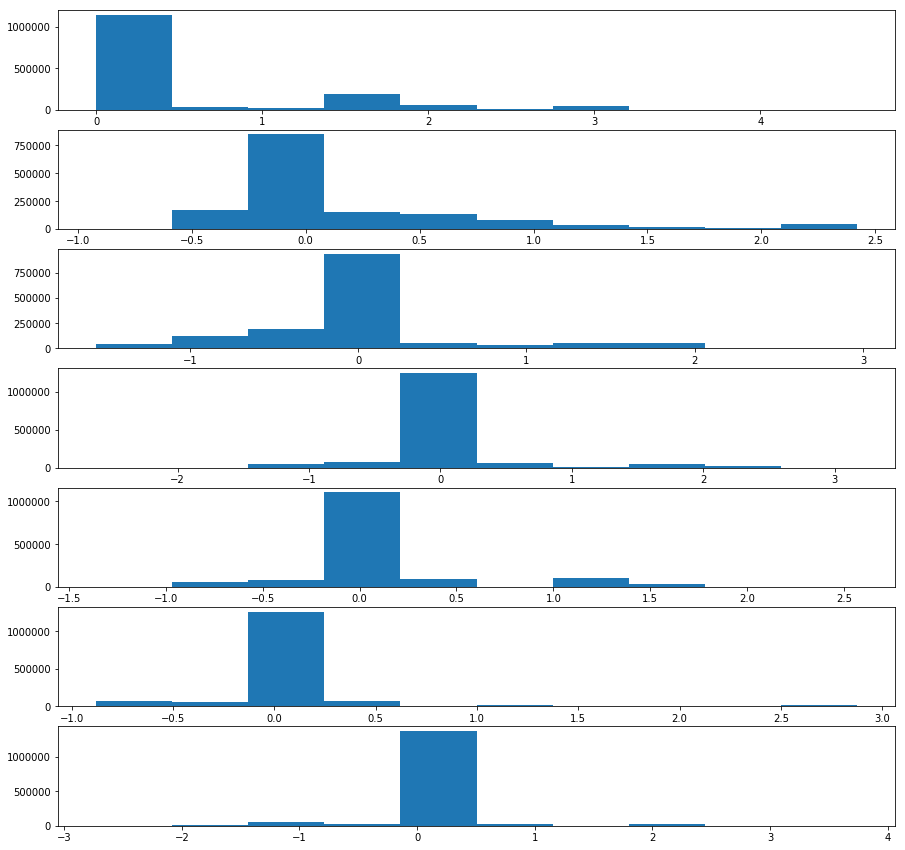

In [15]:
plt.figure(figsize=(15, 15))
for i in range(7):
    plt.subplot(7, 1, i+1)
    plt.hist(train_svd.iloc[:, i])

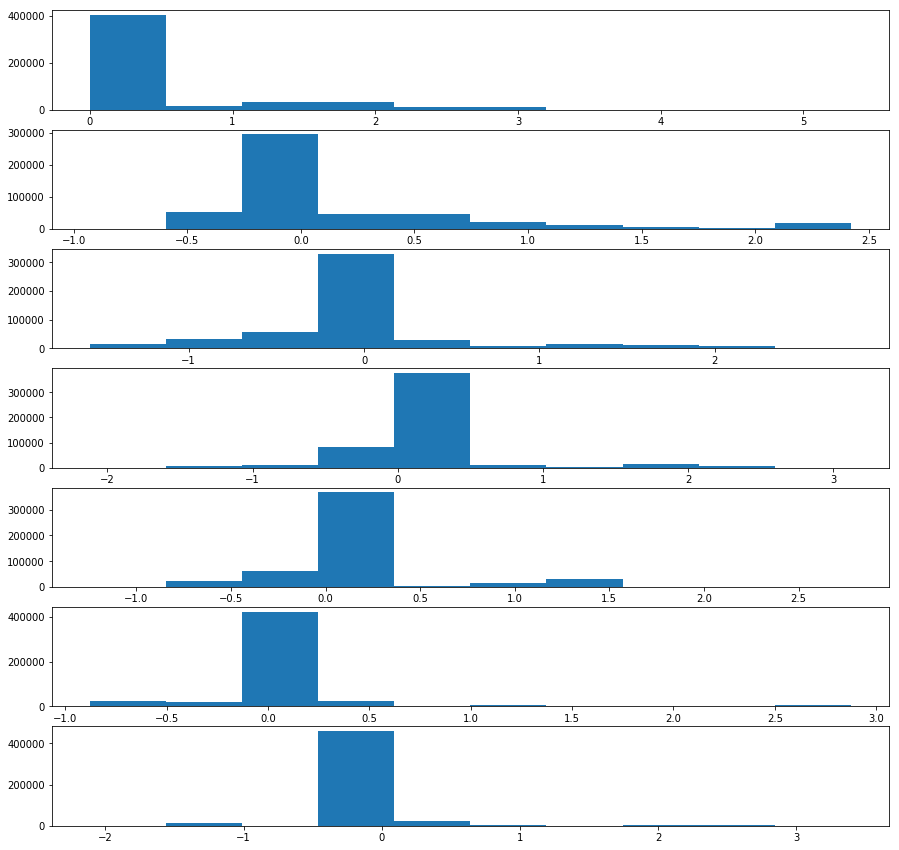

In [16]:
plt.figure(figsize=(15, 15))
for i in range(7):
    plt.subplot(7, 1, i+1)
    plt.hist(test_svd.iloc[:, i])

In [3]:
# Add active data
cols = ['title', 'description']
files = ['../input/train.csv', '../input/test.csv', '../input/train_active.csv', '../input/test_active.csv']
feather_names = ['../input/train_', '../input/test_', '../input/train_active_', '../input/test_active_']
for col in cols:
    for file, feather_name in zip(files, feather_names):    
        df = pd.read_csv(file, usecols=[col])
        print(df.shape)
        df[col] = df[col].fillna('missing')
        df[col] = df[col].apply(lambda x: cleanName(x))
        print(df.shape)
        df.to_feather(feather_name+col+'.feather')
        del df
        gc.collect()


(1503424, 1)
(1503424, 1)
(508438, 1)
(508438, 1)
(14129821, 1)
(14129821, 1)
(12824068, 1)
(12824068, 1)
(1503424, 1)
(1503424, 1)
(508438, 1)
(508438, 1)
(14129821, 1)
(14129821, 1)


TypeError: Cannot convert pyarrow.lib.ChunkedArray to pyarrow.lib.Array

In [ ]:
russian_stop = set(stopwords.words('russian'))

train = pd.read_feather('../input/train_title.feather')
tset = pd.read_feather('../input/test_title.feather')
train_active = pd.read_feather('../input/train_active_title.feather')
test_active = pd.read_feather('../input/test_active_title.feather')

df = pd.concat([train, test, train_active, test_active])
del train, test, train_active, test_active
gc.collect()

cv = CountVectorizer(ngram_range=(1, 2),
                     stop_words = russian_stop,
                     preprocessor=get_col('title')
                    )
ready_df = cv.fit_transform(df.to_dit('records'))
train_df = ready_df[:lentrain, :]
test_df = ready_df[lentrain:lentrain+lentest, :]
print(train_df.shape)
print(test_df.shape)
print(ready_df.shape)

del df, cv, ready_df
gc.collect()

train = pd.read_feather('../input/train_description.feather')
tset = pd.read_feather('../input/test_description.feather')
train_active = pd.read_feather('../input/train_active_description.feather')
test_active = pd.read_feather('../input/test_active_description.feather')

df = pd.concat([train, test, train_active, test_active])
del train, test, train_active, test_active
gc.collect()

tfidf_para = {
    "stop_words": russian_stop,
    "analyzer": 'word',
    "token_pattern": r'\w{1,}',
    "sublinear_tf": True,
    "dtype": np.float32,
    "norm": 'l2',
    "smooth_idf":False
}
tv = TfidfVectorizer(ngram_range=(1, 2),
                     max_features=17000,
                     **tfidf_para,
                     preprocessor=get_col('description')
                    )

ready_df = cv.fit_transform(df.to_dit('records'))
del df; gc.collect()
train_df_1 = ready_df[:lentrain, :]
test_df_1 = ready_df[lentrain:lentrain+lentest, :]
print(train_df_1.shape)
print(test_df_1.shape)
print(ready_df.shape)
del tv, ready_df
gc.collect()

train_df = np.

In [ ]:
# Word + n-Char

In [3]:
train = pd.read_csv('../input/train.csv', usecols=['description', 'title', 'param_1', 'param_2', 'param_3'])
test = pd.read_csv('../input/test.csv', usecols=['description', 'title', 'param_1', 'param_2', 'param_3'])

train['title'] = train['title'].fillna('missing')
train['description'] = train['description'].fillna('missing')
train['param_1'] = train['param_1'].fillna('missing')
train['param_2'] = train['param_2'].fillna('')
train['param_3'] = train['param_3'].fillna('')
train['title'] = train['title'].apply(lambda x: cleanName(x))
train["description"]   = train["description"].apply(lambda x: cleanName(x))
train['param_1'] = train['param_1'].apply(lambda x: cleanName(x))
train['param_2'] = train['param_2'].apply(lambda x: cleanName(x))
train['param_3'] = train['param_3'].apply(lambda x: cleanName(x))


test['title'] = test['title'].fillna('missing')
test['description'] = test['description'].fillna('missing')
test['param_1'] = test['param_1'].fillna('missing')
test['param_2'] = test['param_2'].fillna('')
test['param_3'] = test['param_3'].fillna('')
test['title'] = test['title'].apply(lambda x: cleanName(x))
test["description"]   = test["description"].apply(lambda x: cleanName(x))
test['param_1'] = test['param_1'].apply(lambda x: cleanName(x))
test['param_2'] = test['param_2'].apply(lambda x: cleanName(x))
test['param_3'] = test['param_3'].apply(lambda x: cleanName(x))

train['title_description'] = (train['title']+" "+train['description']).astype(str)
#train['title_param'] = (train['title']+' '+train['param_1']+' '+train['param_2']+' '+train['param_3']).astype(str)
train.drop(['description', 'title', 'param_1', 'param_2', 'param_3'], axis=1, inplace=True)

test['title_description'] = (test['title']+" "+test['description']).astype(str)
#test['title_param'] = (test['title']+' '+test['param_1']+' '+test['param_2']+' '+test['param_3']).astype(str)
test.drop(['description', 'title', 'param_1', 'param_2', 'param_3'], axis=1, inplace=True)

print(train.shape)
print(test.shape)

(1503424, 1)
(508438, 1)


In [4]:
df = pd.concat([train, test])
del train, test
gc.collect()
df.shape

(2011862, 1)

In [5]:
russian_stop = set(stopwords.words('russian'))
tfidf_para = {
    "stop_words": russian_stop,
    "analyzer": 'word',
    "token_pattern": r'\w{1,}',
    "sublinear_tf": True,
    "dtype": np.float32,
    "norm": 'l2',
    "smooth_idf":False
}

def get_col(col_name):
    return lambda x: x[col_name]

vectorizer = FeatureUnion([
        ('title_description',TfidfVectorizer(
            ngram_range=(1, 2),
            max_features=17000,
            **tfidf_para,
            preprocessor=get_col('title_description'))),
        ('title_decsription_char',TfidfVectorizer(
            stop_words = russian_stop,
            preprocessor=get_col('title_description'),
            sublinear_tf=True,
            strip_accents='unicode',
            analyzer='char',
            ngram_range=(2, 4),
            max_features=30000,
            smooth_idf=False,
            token_pattern=r'\w{1,}',
            dtype=np.float32
        ))
    ])

vectorizer.fit(df.to_dict('records'))
ready_df = vectorizer.transform(df.to_dict('records'))


MemoryError: 

In [ ]:
train_df = ready_df[:lentrain]
y = pd.read_csv('../input/train.csv', usecols=['deal_probability'])


In [ ]:
ridge_params = {'alpha':30.0, 'fit_intercept':True, 'normalize':False, 'copy_X':True,
                'max_iter':None, 'tol':0.001, 'solver':'auto', 'random_state':786}
ridge = Ridge(**ridge_params)
ridge.fit(train_df, y)
pred_ridge = ridge.predict(ready_df)


In [ ]:
train_ridge = pred_ridge[:lentrain]
test_ridge = pred_ridge[lentrain:]

print(train_ridge.shape)
print(test_ridge.shape)


In [ ]:
train_ridge_df = pd.DataFrame()
test_ridge_df = pd.DataFrame()
train_ridge_df['tfidf_td_wordchar_ridge'] = pd.Series(train_ridge.flatten())
test_ridge_df['tfidf_td_wordchar_ridge'] = pd.Series(test_ridge.flatten())

train_ridge_df.to_feather('../features/train/tfidf_td_wordchar_ridge_train.feather')
test_ridge_df.to_feather('../features/test/tfidf_td_wordchar_ridge_test.feather')


In [ ]:
del train_df, y, ridge, pred_ridge, train_ridge, test_ridge, train_ridge_df, test_ridge_df
gc.collect()

In [ ]:
n_comp = 6
tsvd = TruncatedSVD(n_components=n_comp, algorithm='arpack')
pred_tsvd = tsvd.fit_transform(ready_df)

train_svd = pd.DataFrame(pred_tsvd[:lentrain])
test_svd = pd.DataFrame(pred_tsvd[lentrain:])
train_svd.columns = ['svd_tfidf_td_wordchar_'+str(i+1) for i in range(n_comp)]
test_svd.columns =  ['svd_tfidf_td_wordchar_'+str(i+1) for i in range(n_comp)]

print(train_svd.shape)
print(test_svd.shape)
train_svd.head()

In [ ]:
test_svd.head()

In [ ]:
train_svd.to_feather('../features/train/tfidf_td_wordchar_tsvd_train.feather')
train_svd.to_feather('../features/test/tfidf_td_wordchar_tsvd_test.feather')
